<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Graph-layout" data-toc-modified-id="Graph-layout-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Graph layout</a></span></li><li><span><a href="#Color-compounds-by-omics-level-and-pvalue" data-toc-modified-id="Color-compounds-by-omics-level-and-pvalue-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Color compounds by omics level and pvalue</a></span></li></ul></div>

In [1]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import networkx as nx
import seaborn as sns
import matplotlib as mpl

from matplotlib_venn import venn2, venn3
%matplotlib inline

np.random.seed(0)

In [2]:
rna_edges = pd.read_parquet('../results/rna_compound_edges.parquet')
wgs_edges = pd.read_parquet('../results/wgs_compound_edges.parquet')
amp_edges = pd.read_parquet('../results/amp_compound_edges.parquet')

In [3]:
edges = pd.concat((wgs_edges, amp_edges, rna_edges))
edges = edges.drop_duplicates()

In [4]:
graph = nx.from_pandas_edgelist(edges, 'src', 'dest')

In [5]:
nx.number_connected_components(graph)

2

In [6]:
components = nx.connected_components(graph)

In [7]:
for c in components:
    print('Nodes', len(c))

Nodes 5363
Nodes 64


# Graph layout

In [8]:
components = nx.connected_components(graph)
comp = next(components) # get first component, since it is the largest

In [9]:
#pos.loc[list(comp)].to_csv('../results/connected_compound_positions.csv')
pos = pd.read_csv('../results/compound_positions.csv', index_col=0)

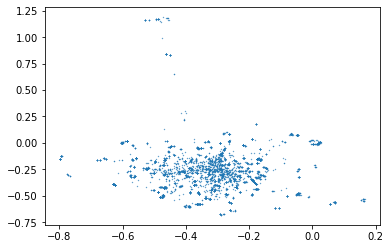

In [10]:
cpos = pos.loc[list(comp)]
epos = pos.loc[list(set(pos.index) - comp)]
k = 4
off = 0.3
cpos = cpos * k - off
plt.scatter(cpos.values[:, 0], cpos.values[:, 1], s=.1)
#plt.scatter(epos.values[:, 0], epos.values[:, 1], s=1)

In [11]:
#new_pos = pd.concat((cpos, epos))
new_pos = cpos

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


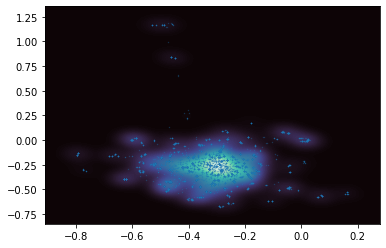

In [12]:
sns.kdeplot(new_pos.values[:, 0], new_pos.values[:, 1], cmap='mako', fill=True, thresh=0, levels=100)
plt.scatter(cpos.values[:, 0], cpos.values[:, 1], s=.1, alpha=0.5)
#plt.scatter(epos.values[:, 0], epos.values[:, 1], s=1)

# Color compounds by omics level and pvalue

In [13]:
rna_compounds = pd.read_csv('../results/RNA_compounds.csv', index_col=0)
wgs_compounds = pd.read_csv('../results/WGS_compounds.csv', index_col=0)
amp_compounds = pd.read_csv('../results/16S_compounds.csv', index_col=0)

In [14]:
rna_logpvals = rna_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()
wgs_logpvals = wgs_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()
amp_logpvals = amp_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()

In [15]:
wgs_pos = pd.merge(new_pos, wgs_logpvals, left_index=True, right_index=True)
amp_pos = pd.merge(new_pos, amp_logpvals, left_index=True, right_index=True)
rna_pos = pd.merge(new_pos, rna_logpvals, left_index=True, right_index=True)

In [16]:
len(set(amp_pos.index) - set(wgs_pos.index))

183

In [17]:
microb = pd.concat((amp_pos, wgs_pos))
new_pos = pd.concat((amp_pos, wgs_pos, rna_pos))

<AxesSubplot:xlabel='-log(pvalue)', ylabel='Count'>

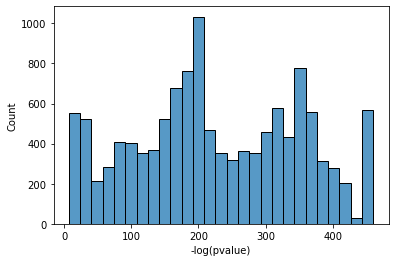

In [18]:
sns.histplot(new_pos['-log(pvalue)'])

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No handles with labels found to put in legend.


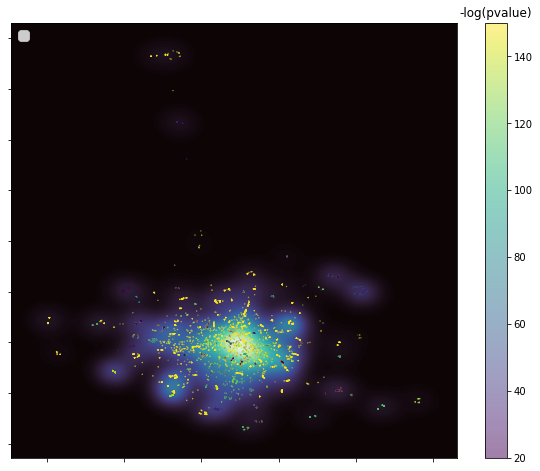

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.kdeplot(new_pos.values[:, 0], new_pos.values[:, 1], cmap='mako', fill=True, thresh=0, levels=100, ax=ax)
norm = mpl.colors.Normalize(vmin=20, vmax=150)
cbar = ax.scatter(new_pos.values[:, 0], new_pos.values[:, 1], s=.1, c=new_pos['-log(pvalue)'], 
                  norm=norm, alpha=0.5)
#ax.scatter(rna_pos.values[:, 0], rna_pos.values[:, 1], s=1, c='r', marker='x', label='RNAseq')

ax.set_xticklabels([])
ax.set_yticklabels([])
clb = plt.colorbar(cbar)
clb.ax.set_title('-log(pvalue)')
lgnd = ax.legend(loc=2, fontsize=14)
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])

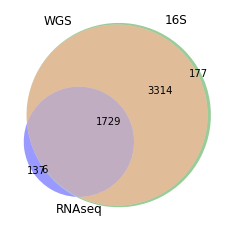

In [20]:
venn3([set(wgs_pos.index), set(amp_pos.index), set(rna_pos.index)], ['WGS', '16S', 'RNAseq'])

In [21]:
rna_compounds = pd.read_csv('../results/RNA_compounds.csv', index_col=0)
wgs_compounds = pd.read_csv('../results/WGS_compounds.csv', index_col=0)
amp_compounds = pd.read_csv('../results/16S_compounds.csv', index_col=0)

In [22]:
rna_compounds.Name.value_counts().head(50)

Bile secretion - Homo sapiens (human)                                         696
Neuroactive ligand-receptor interaction - Homo sapiens (human)                416
Pathways in cancer - Homo sapiens (human)                                     403
Metabolism of xenobiotics by cytochrome P450 - Homo sapiens (human)           242
Diabetic cardiomyopathy - Homo sapiens (human)                                234
Drug metabolism - cytochrome P450 - Homo sapiens (human)                      200
Pathways of neurodegeneration - multiple diseases - Homo sapiens (human)      192
Glycerophospholipid metabolism - Homo sapiens (human)                         165
Arginine and proline metabolism - Homo sapiens (human)                        156
cAMP signaling pathway - Homo sapiens (human)                                 150
Porphyrin and chlorophyll metabolism - Homo sapiens (human)                   143
Thermogenesis - Homo sapiens (human)                                          115
Alzheimer diseas

In [23]:
nucleotide = ['Amino sugar and nucleotide sugar metabolism', 
              'Pyrimidine metabolism', 'Purine metabolism']
amino_acid = ['Arginine and proline metabolism',
              'Phenylalanine metabolism', 
              'Tyrosine metabolism', 
              'Lysine degradation',
              'Glycine, serine and threonine metabolism',
              'Histidine metabolism',
              'Valine, leucine and isoleucine degradation',
              'Cysteine and methionine metabolism']
carbohydrate = ['Fructose and mannose metabolism', 
                'Glyoxylate and dicarboxylate metabolism',
                'Fatty acid degradation',
                'Starch and sucrose metabolism',
                'Pentose phosphate pathway',
                'Propanoate metabolism',
                'Butanoate metabolism',
                'Nicotinate and nicotinamide metabolism']
lipid = ['Glycerolipid metabolism', 'Glycerophospholipid metabolism']

In [24]:
def wgs_pathway_f(x):
    if x['Name'] in nucleotide:
        return 'Nucleotide\nmetabolism'
    if x['Name'] in amino_acid:
        return 'Amino acid\nmetabolism'
    if x['Name'] in carbohydrate:
        return 'Carbohydrate\nmetabolism'
    if ('lipid' in x['Name'] or 'Lipid' in x['Name']) and 'metabolism' in x['Name']:
        return 'Lipid\nmetabolism'
wgs_compounds['Pathway_name'] = wgs_compounds.apply(wgs_pathway_f, axis=1)

In [25]:
wgs_compounds['Pathway_name'].value_counts()

Nucleotide\nmetabolism      24550
Carbohydrate\nmetabolism    21037
Amino acid\nmetabolism      19767
Lipid\nmetabolism            3665
Name: Pathway_name, dtype: int64

In [26]:
human_pathways = ['Pathways of neurodegeneration - multiple diseases - Homo sapiens (human)',
                  'Fatty acid degradation - Homo sapiens (human)',
                  'Tryptophan metabolism - Homo sapiens (human)',
                  'Purine metabolism - Homo sapiens (human)',
                  'Bile secretion - Homo sapiens (human)',
                  'Carbohydrate digestion and absorption - Homo sapiens (human)']


def human_pathway_f(x):
    if x['Name'] == 'Pathways of neurodegeneration - multiple diseases - Homo sapiens (human)':
        return 'Neuro-\ndegeneration'
    if x['Name'] == 'Fatty acid degradation - Homo sapiens (human)':
        return 'Fatty acid \ndegradation'
    if x['Name'] == 'Tryptophan metabolism - Homo sapiens (human)':
        return 'Tryptophan\nmetabolism'
    #if x['Name'] == 'Bile secretion - Homo sapiens (human)':
    #    return 'Bile \n secretion'
    if x['Name'] == 'Purine metabolism - Homo sapiens (human)':
        return 'Purine\nmetabolism'
    if x['Name'] == 'Carbohydrate digestion and absorption - Homo sapiens (human)':
        return 'Carbohydrate\ndigestion\nand absorption'
rna_compounds['Pathway_name'] = rna_compounds.apply(human_pathway_f, axis=1)

In [27]:
# remove redundancy
new_pos = new_pos.reset_index().groupby('index').max()

In [28]:
cmap = plt.get_cmap('Greens')

wgs_attr = {
    'Nucleotide\nmetabolism': {'dx': 0, 'dy': 0.2, 'color': cmap(0.7)},
    'Carbohydrate\nmetabolism': {'dx': -0.55, 'dy': -0.1, 'color': cmap(0.8)},
    'Amino acid\nmetabolism': {'dx': 0.15, 'dy': -0.35, 'color': cmap(0.9)},
    'Lipid\nmetabolism': {'dx': -0.2, 'dy': 0.2, 'color': cmap(1.0)}
}

cmap = plt.get_cmap('YlOrBr')
rna_attr = {
    'Neuro-\ndegeneration': {'dx': 0.2, 'dy': -0.1, 'color': cmap(0.6)},
    'Fatty acid \ndegradation': {'dx': -0.4, 'dy': -0.35, 'color': cmap(0.9)},
    'Tryptophan\nmetabolism': {'dx': -0.15, 'dy': -0.3, 'color': cmap(0.7)},
    'Purine\nmetabolism': {'dx': 0.2, 'dy': 0.1, 'color': cmap(0.5)},
    'Carbohydrate\ndigestion\nand absorption': {'dx': -0.5, 'dy': -0, 'color': cmap(1.0)}
}

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No handles with labels found to put in legend.


(-0.9, 0.4, -0.9, 0.4)

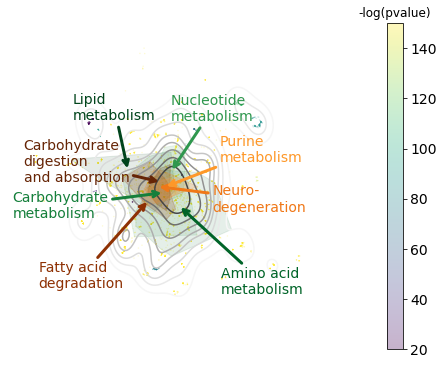

In [29]:
from scipy.spatial import ConvexHull
import matplotlib.patches as mpatches 

fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(new_pos.values[:, 0], new_pos.values[:, 1], 
            cmap='Greys', fill=False, thresh=0, levels=10, ax=ax)

for name, df in wgs_compounds.groupby('Pathway_name'):
    compounds = df['Compound'].unique()
    points = new_pos.loc[compounds, ['0', '1']].values
    hull = ConvexHull(points)
    dx, dy, color = wgs_attr[name]['dx'], wgs_attr[name]['dy'], wgs_attr[name]['color']
    #ax.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
    tri = mpatches.Polygon(points[hull.vertices], closed=True, color=color, alpha=0.1)   
    ax.add_patch(tri)     
    ax.annotate(name, xy=points.mean(0), xytext=points.mean(0) + np.array([dx, dy]),
                xycoords='data',
                arrowprops=dict(arrowstyle= '->',
                             color=color,
                             lw=3,
                             ls='-'),
                color=color, fontsize=14)
    
for name, df in rna_compounds.groupby('Pathway_name'):
    compounds = df['Compound'].unique()
    compounds = list(set(compounds) & set(new_pos.index))
    points = new_pos.loc[compounds, ['0', '1']].values
    hull = ConvexHull(points)
    dx, dy, color = rna_attr[name]['dx'], rna_attr[name]['dy'], rna_attr[name]['color']
    tri = mpatches.Polygon(points[hull.vertices], closed=True, color=color, alpha=0.2)   
    ax.add_patch(tri)     
    ax.annotate(name, xy=points.mean(0), xytext=points.mean(0) + np.array([dx, dy]),
                xycoords='data',
                arrowprops=dict(arrowstyle= '->',
                             color=color,
                             lw=3,
                             ls='-'),
                color=color, fontsize=14)
    
norm = mpl.colors.Normalize(vmin=20, vmax=150)
cbar = ax.scatter(new_pos.values[:, 0], new_pos.values[:, 1], s=.1, c=new_pos['-log(pvalue)'], 
                  norm=norm, alpha=0.3)

clb = plt.colorbar(cbar)
clb.ax.set_title('-log(pvalue)')
lgnd = ax.legend(loc=2, fontsize=16)

#ax.set_xticklabels([])
#ax.set_yticklabels([])
ax.set_xlim([-0.9, 0.4])
ax.set_ylim([-0.9, 0.4])
ax.get_legend().remove()
clb.ax.tick_params(labelsize=14) 
fig.patch.set_visible(False)
ax.axis('off')